📂 모델 및 테스트 데이터 로딩 중...
   -> Baseline 모델 로드 완료
   -> RandomForest 모델 로드 완료
   -> XGBoost 모델 로드 완료
   -> LightGBM 모델 로드 완료
   -> 테스트 데이터 로드 완료

📊 [모델 성능 비교 리포트]
Baseline        | RMSE: 2162.73 | R2: 0.6062 | NMAE: 0.4998
RandomForest    | RMSE: 841.04 | R2: 0.9404 | NMAE: 0.1297
XGBoost         | RMSE: 706.75 | R2: 0.9579 | NMAE: 0.1056
LightGBM        | RMSE: 837.71 | R2: 0.9409 | NMAE: 0.1449

📈 [시각화 1] 모델별 성능 비교 (RMSE, R2, NMAE)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21248\2651690577.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='RMSE', ax=axes[0], palette='Reds')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21248\2651690577.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R2', ax=axes[1], palette='Blues')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21248\2651690577.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='NMAE'

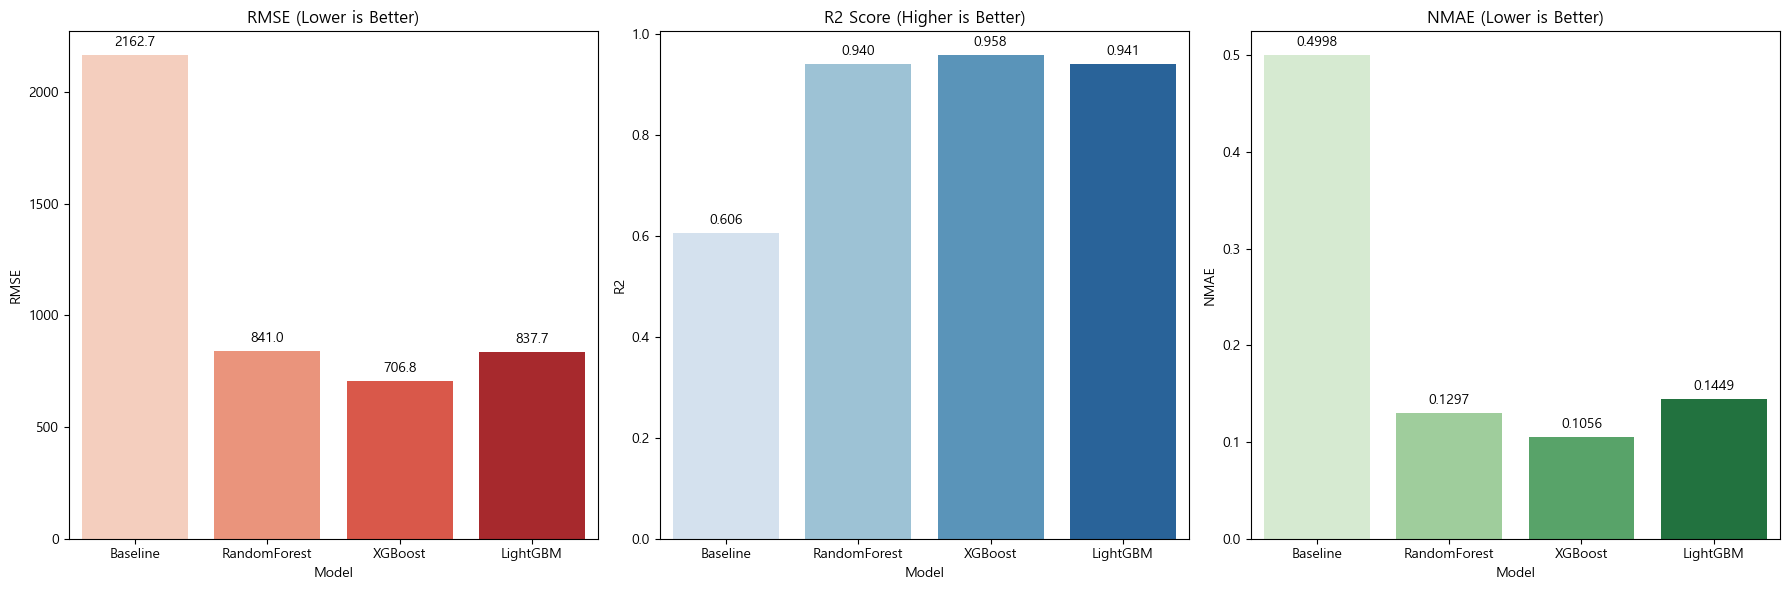


📈 [시각화 2] 예측 성능 상세 분석
   -> Actual vs Predicted Scatter Plot 생성 중...


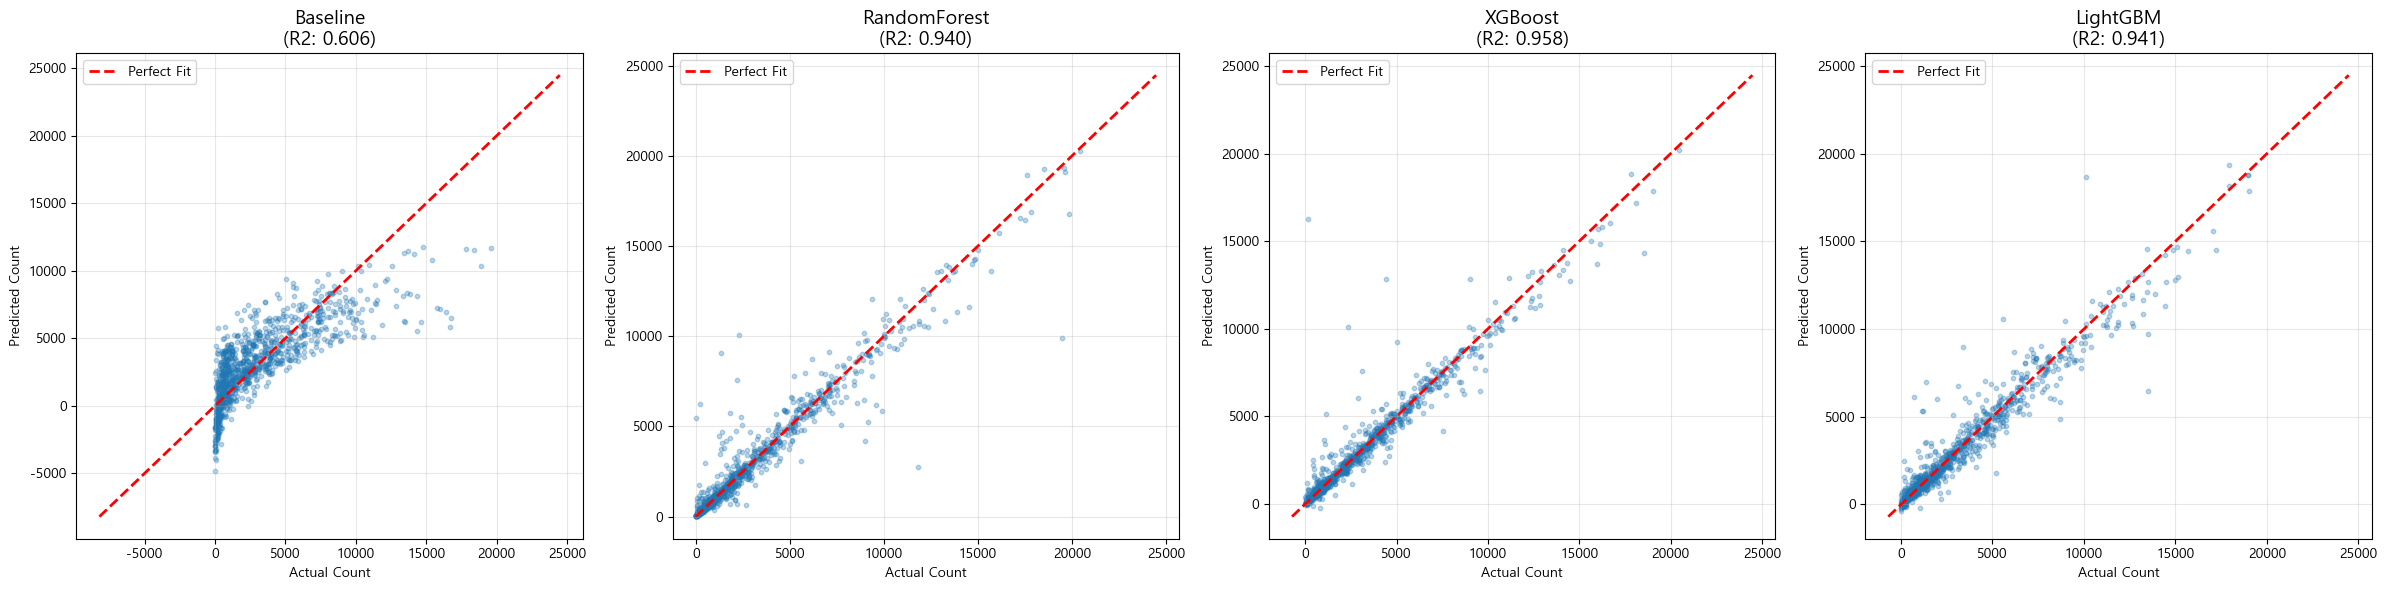

   -> Sample Tracking Plot (Subset 50 samples) 생성 중...


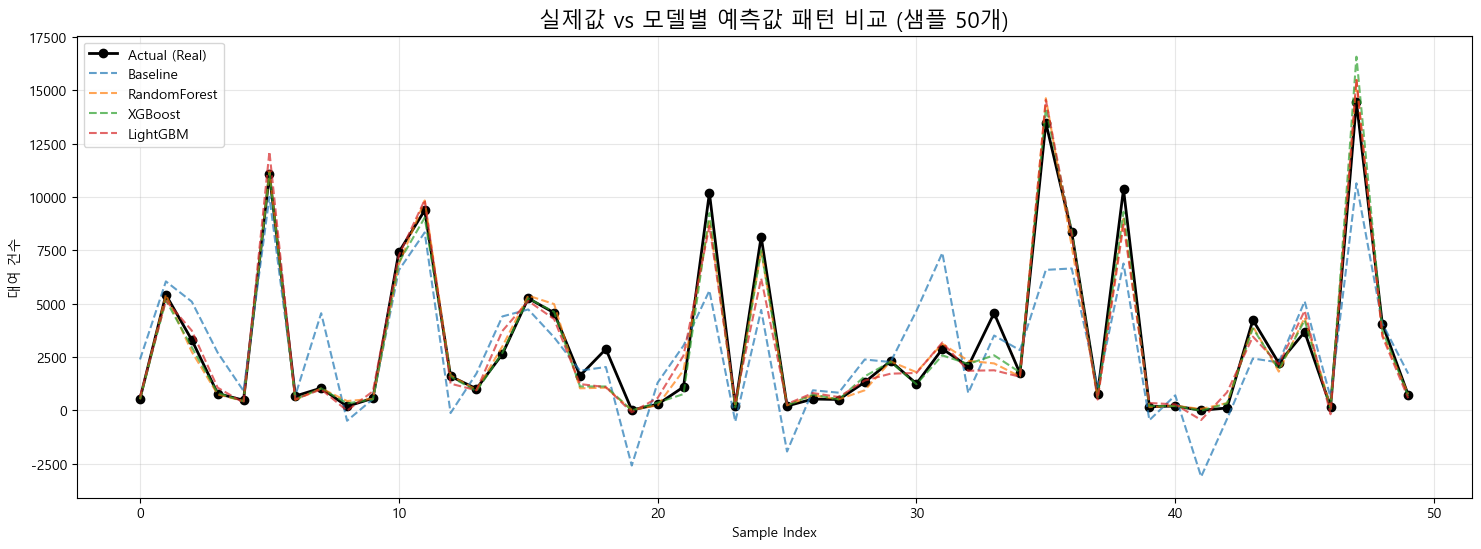

   -> Error (Residual) Distribution Plot 생성 중...


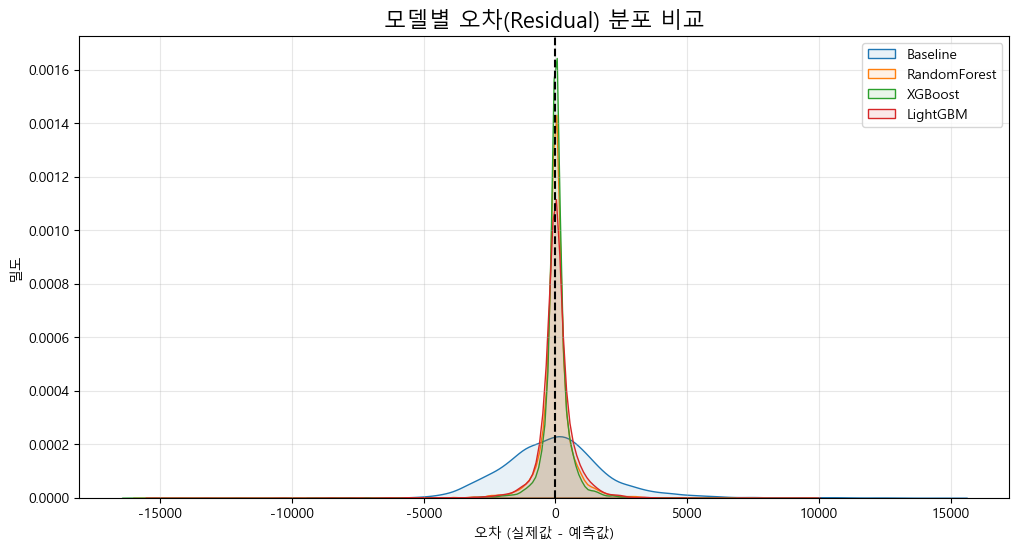


🔍 [XAI] SHAP 분석 시작
🏆 분석 대상 Best Model: XGBoost
⏳ 100개 샘플에 대해 SHAP 값 계산 중...


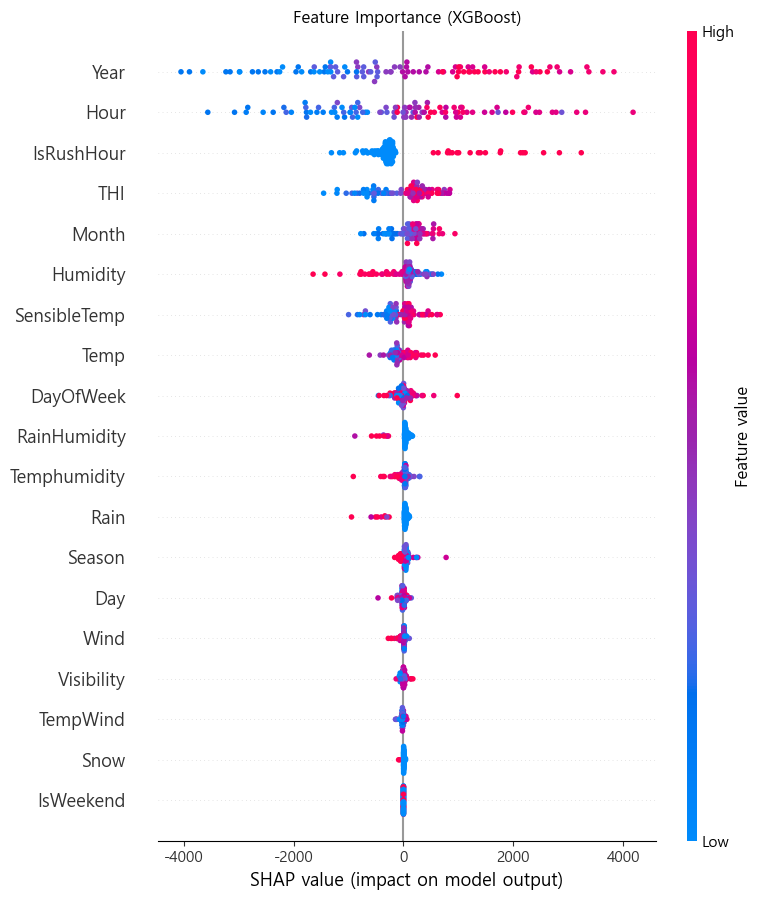

✅ SHAP 분석 완료!


In [1]:
# -------------------------------------------------------
# [필수] 라이브러리 설치
# -------------------------------------------------------
!pip install shap xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import platform
import os
from tqdm import tqdm

# -------------------------------------------------------
# 1. 한글 폰트 설정
# -------------------------------------------------------
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# -------------------------------------------------------
# 2. 모델 및 테스트 데이터 로드
# -------------------------------------------------------
print("📂 모델 및 테스트 데이터 로딩 중...")

model_paths = {
    'Baseline': 'baseline_model.pkl',
    'RandomForest': 'rf_model.pkl',
    'XGBoost': 'xgb_model.pkl',
    'LightGBM': 'lgbm_model.pkl'
}

loaded_models = {}
for name, path in model_paths.items():
    if os.path.exists(path):
        print(f"   -> {name} 모델 로드 완료")
        loaded_models[name] = joblib.load(path)
    else:
        print(f"   ⚠️ {path} 파일을 찾을 수 없습니다. (Skip)")

if not loaded_models:
    print("❌ 로드된 모델이 없습니다. modeling.ipynb를 먼저 실행하여 모델을 학습시켜주세요.")
    exit()

if os.path.exists('X_test.csv') and os.path.exists('y_test.csv'):
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv')
    print("   -> 테스트 데이터 로드 완료")
else:
    print("❌ 테스트 데이터(X_test.csv, y_test.csv)가 없습니다. modeling.ipynb를 확인하세요.")
    exit()

# -------------------------------------------------------
# 3. 모델 성능 비교 평가 (Evaluation)
# -------------------------------------------------------
print("\n📊 [모델 성능 비교 리포트]")
results = []
predictions = {}

# [추가] NMAE 계산 함수 정의
def calculate_nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    score = mae / np.mean(np.abs(y_true))
    return score

for name, model in loaded_models.items():
    # 예측 수행
    pred = model.predict(X_test)
    predictions[name] = pred
    
    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    nmae = calculate_nmae(y_test, pred) # NMAE 계산
    
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2, 'NMAE': nmae})
    print(f"{name:<15} | RMSE: {rmse:.2f} | R2: {r2:.4f} | NMAE: {nmae:.4f}")

# 데이터프레임 변환
results_df = pd.DataFrame(results)

# -------------------------------------------------------
# 4. 성능 비교 시각화 (Bar Chart) - NMAE 추가
# -------------------------------------------------------
print("\n📈 [시각화 1] 모델별 성능 비교 (RMSE, R2, NMAE)")
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 그래프 3개로 확장

# RMSE 비교
sns.barplot(data=results_df, x='Model', y='RMSE', ax=axes[0], palette='Reds')
axes[0].set_title('RMSE (Lower is Better)')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# R2 Score 비교
sns.barplot(data=results_df, x='Model', y='R2', ax=axes[1], palette='Blues')
axes[1].set_title('R2 Score (Higher is Better)')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# [추가] NMAE 비교
sns.barplot(data=results_df, x='Model', y='NMAE', ax=axes[2], palette='Greens')
axes[2].set_title('NMAE (Lower is Better)')
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 5. 예측값 상세 시각화
# -------------------------------------------------------
print("\n📈 [시각화 2] 예측 성능 상세 분석")

# (1) Actual vs Predicted (산점도)
print("   -> Actual vs Predicted Scatter Plot 생성 중...")
n_models = len(loaded_models)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6))
if n_models == 1: axes = [axes]

for i, (name, pred) in enumerate(predictions.items()):
    indices = np.random.choice(len(y_test), min(1000, len(y_test)), replace=False)
    ax = axes[i]
    ax.scatter(y_test.iloc[indices], pred[indices], alpha=0.3, s=10, color='#1f77b4')
    
    data_min = min(y_test.min().item(), pred.min())
    data_max = max(y_test.max().item(), pred.max())
    ax.plot([data_min, data_max], [data_min, data_max], 'r--', lw=2, label='Perfect Fit')
    
    current_r2 = results_df[results_df['Model'] == name]['R2'].values[0]
    ax.set_title(f"{name}\n(R2: {current_r2:.3f})", fontsize=14)
    ax.set_xlabel("Actual Count")
    ax.set_ylabel("Predicted Count")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# (2) Sample Tracking (라인 차트)
print("   -> Sample Tracking Plot (Subset 50 samples) 생성 중...")
plt.figure(figsize=(18, 6))
subset_slice = slice(0, 50)
y_test_reset = y_test.reset_index(drop=True)
plt.plot(y_test_reset[subset_slice], label='Actual (Real)', color='black', linewidth=2, marker='o')

for i, (name, pred) in enumerate(predictions.items()):
    plt.plot(pred[subset_slice], label=f'{name}', linestyle='--', alpha=0.7)

plt.title("실제값 vs 모델별 예측값 패턴 비교 (샘플 50개)", fontsize=16)
plt.xlabel("Sample Index")
plt.ylabel("대여 건수")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# (3) Residual Distribution (오차 분포)
print("   -> Error (Residual) Distribution Plot 생성 중...")
plt.figure(figsize=(12, 6))
for name, pred in predictions.items():
    residuals = y_test.values.flatten() - pred
    sns.kdeplot(residuals, label=name, fill=True, alpha=0.1)
plt.axvline(0, color='black', linestyle='--')
plt.title("모델별 오차(Residual) 분포 비교", fontsize=16)
plt.xlabel("오차 (실제값 - 예측값)")
plt.ylabel("밀도")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# -------------------------------------------------------
# 6. XAI (SHAP) 분석 - 최고 성능 모델 기준
# -------------------------------------------------------
print("\n🔍 [XAI] SHAP 분석 시작")
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = loaded_models[best_model_name]
print(f"🏆 분석 대상 Best Model: {best_model_name}")

try:
    sample_size = 100
    X_sample = X_test.sample(sample_size, random_state=42)
    print(f"⏳ {sample_size}개 샘플에 대해 SHAP 값 계산 중...")
    
    if best_model_name in ['RandomForest', 'XGBoost', 'LightGBM']:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_sample)
    else:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)

    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()
    print("✅ SHAP 분석 완료!")

except Exception as e:
    print(f"⚠️ SHAP 분석 중 오류 발생: {e}")